# Demo: Register SmartSPIM Data To CCF v3.1 Mouse Brain Atlas

## Overview

This notebook demonstrates a reproducible registration pipeline to align downsampled SmartSPIM data to the Allen Mouse Brain Common Coordinate Framework (CCF)$^1$. The notebook can be run interactively in CodeOcean to evaluate intermediate results or can be run from start to end for reproducible results in the CodeOcean capsule$^2$.

## Inputs

1. Target (fixed) image. The CCF v3.1 atlas with updated spacing and spatial orientation is available in NIFTI format at http://download.alleninstitute.org/informatics-archive/converted_mouse_ccf/average_template/. More information on the CCF atlas is available at http://help.brain-map.org/display/mouseconnectivity/API

2. Source (moving) image. Stitched SmartSPIM mouse brain images are available on the AWS S3 "aind-open-data" bucket in Zarr format. The largest resolution / smallest image size is used here for performance considerations.

## Outputs

1. Registered source (moving) image aligned to CCF atlas space.

2. ITK multistage composite transform mapping from source to target space.

## Assumptions

1. The source and target images are spatially oriented to common anatomical directions. This can be confirmed with a 3D spatial viewer such as 3D Slicer, ITKWidgets, or Neuroglancer. Note that viewers displaying voxel data without spatial information such as matplotlib may produce misleading visuals showing data aligned to different anatomical axes.

2. The source image contains correct metadata. In this notebook the Zarr input sample is updated with known spatial metadata.

## Procedure

1. Data is read in from their respective stores attached via CodeOcean's data attachment mechanism.

2. An initial translation is constructed to coarsely superimpose the source image on the target image. The source image is updated in place without resampling.

3. The source image is registered to the target image. ITKElastix is used to optimize three transform stages for rigid, affine, and then deformable registration.

4. Results are written out.

## References

1. Quanxin Wang, Song-Lin Ding, Yang Li, Josh Royall, David Feng, Phil Lesnar, Nile Graddis, Maitham Naeemi, Benjamin Facer, Anh Ho, Tim Dolbeare, Brandon Blanchard, Nick Dee, Wayne Wakeman, Karla E. Hirokawa, Aaron Szafer, Susan M. Sunkin, Seung Wook Oh, Amy Bernard, John W. Phillips, Michael Hawrylycz, Christof Koch, Hongkui Zeng, Julie A. Harris, Lydia Ng,
The Allen Mouse Brain Common Coordinate Framework: A 3D Reference Atlas, Cell, Volume 181, Issue 4, 2020, Pages 936-953.e20, ISSN 0092-8674, https://doi.org/10.1016/j.cell.2020.04.007

2. https://help.codeocean.com/en/articles/1111013-rendering-jupyter-notebooks-to-html

## Initialize Notebook

In [1]:
import os
import itertools

import itk
import itkwidgets
import numpy as np
import ome_zarr
from ome_zarr.reader import Reader as OMEZarrReader
from ome_zarr.io import ZarrLocation
import ome_zarr.utils

assert "ElastixRegistrationMethod" in dir(itk)  # Ensure itk-elastix is installed

In [2]:
SOURCE_IMAGE_INPUT_FILEPATH = "../data/SmartSPIM_631680_2022-09-09_13-52-33_stitched_2022-11-10_17-18-18/processed/OMEZarr/Ex_647_Em_690.zarr"
SAMPLE_ID = int(SOURCE_IMAGE_INPUT_FILEPATH.split("_")[1])
SAMPLE_CHANNEL = SOURCE_IMAGE_INPUT_FILEPATH.split("/")[-1].split(".zarr")[0]
SAMPLE_LEVEL = (
    4  # data is scaled down by 2 ^ N in each direction or by 2 ^ 3N in total volume
)
SAMPLE_NAME = f"{SAMPLE_ID}_{SAMPLE_CHANNEL}"

# Also available at http://download.alleninstitute.org/informatics-archive/converted_mouse_ccf/average_template/
TARGET_IMAGE_INPUT_FILEPATH = (
    "../data/allen_mouse_ccf/average_template/average_template_25.nii.gz"
)

REGISTERED_IMAGE_OUTPUT_PATH = f"../results/{SAMPLE_NAME}"
REGISTERED_IMAGE_OUTPUT_FILENAME = f"{SAMPLE_NAME}_registered.nii.gz"

print(f"Registration results will be written to {REGISTERED_IMAGE_OUTPUT_PATH}")

Registration results will be written to ../results/631680_Ex_647_Em_690


## Load SmartSPIM Source Image From Attached S3 Bucket

SmartSPIM images are publicly available from the `aind-open-data` AWS S3 bucket and are mounted in the CodeOcean capsule in the `data` folder. The Allen Institute for Neural Dynamics has stitched the original SmartSPIM TIFF images into multiscale 3D volumes in OME-Zarr format. Additional metadata concerning data collection is made available in the `acquisition.json` file in the corresponding unstitched data folder for a given sample.

We execute three key steps to fetch and initialize SmartSPIM data:

1. Set up the OME-Zarr reader and fetch voxel data from the AWS S3 bucket. For registration demonstration we fetch the most downsampled multiscale level, which is the fourth level here. Each level represents downsampling by 2x in each image direction, so the fourth level is $2^{-4} = \frac{1}{16}$ the resolution of the original stitched SmartSPIM image or $2^{3 * -4} = \frac{1}{4096}$ the volume of the original SmartSPIM image.

2. Parse OME-Zarr metadata to get the scaling along each voxel image direction. Note that the interface for Zarr and ITK voxel images is reversed such that the 0th index in a Zarr image represents the slowest-moving image direction (KJI) whereas the 0th index in an ITK image represents the fastest-moving image direction (IJK). Spacing is updated accordingly.

3. Update the SmartSPIM ITK image to represent the anatomical directions of the collection space. ITK assumes that an image with identity direction aligns to "right-to-left", "anterior-to-posterior", "inferior-to-superior" (LPS) axes in that order. `acquisition.json` contains axis metadata specifying collection axis directions. The sample used in this notebook is collected in "left-to-right", "posterior-to-anterior", "superior-to-inferior" (RAI) space. We update the SmartSPIM ITK image to account for the different in anatomical space conventions, which results in the initial ITK image being spatially oriented to align with the CCF average template.

#### Orientation Before Accounting for Anatomical Space Conventions

![smartspim-before-reorient-2.png](files/images/smartspim-before-reorient.png)



#### Orientation After Accounting for Anatomical Space Conventions

![smartspim-after-reorient-2.png](files/images/smartspim-after-reorient.png)




In [3]:
assert os.path.exists(
    SOURCE_IMAGE_INPUT_FILEPATH
), "Failed to get data! Did you attach the S3 bucket to this capsule?"

In [4]:
# Print information about multiscales available in the OME-Zarr sample
_ = next(ome_zarr.utils.info(SOURCE_IMAGE_INPUT_FILEPATH))

/root/capsule/data/SmartSPIM_631680_2022-09-09_13-52-33_stitched_2022-11-10_17-18-18/processed/OMEZarr/Ex_647_Em_690.zarr [zgroup]
 - metadata
   - Multiscales
   - OMERO
 - data
   - (1, 1, 4200, 10240, 7400)
   - (1, 1, 2100, 5120, 3700)
   - (1, 1, 1050, 2560, 1850)
   - (1, 1, 525, 1280, 925)
   - (1, 1, 262, 640, 462)


In [5]:
zarr_location = ZarrLocation(SOURCE_IMAGE_INPUT_FILEPATH)
reader = OMEZarrReader(zarr_location)
image_node = next(reader())
print(image_node)

/root/capsule/data/SmartSPIM_631680_2022-09-09_13-52-33_stitched_2022-11-10_17-18-18/processed/OMEZarr/Ex_647_Em_690.zarr [zgroup]


In [6]:
# Construct ITK spacing metadata from OME-Zarr metadata
SPATIAL_AXES = ("x", "y", "z")
zarr_spatial_axes = [
    axis["name"] for axis in image_node.metadata["axes"] if axis["name"] in SPATIAL_AXES
]
itk_spatial_axes = zarr_spatial_axes[::-1]

ome_zarr_metadata = image_node.metadata

axis_names = [axis["name"] for axis in ome_zarr_metadata["axes"]]
axis_metadata_indices = {
    axis_name: axis_names.index(axis_name) for axis_name in itk_spatial_axes
}
axis_units = {
    axis_name: next(
        axis for axis in ome_zarr_metadata["axes"] if axis["name"] == axis_name
    )["unit"]
    for axis_name in itk_spatial_axes
}

axis_spacings = {
    axis_name: ome_zarr_metadata["coordinateTransformations"][0][0]["scale"][axis_index]
    * (2**SAMPLE_LEVEL)
    for axis_name, axis_index in axis_metadata_indices.items()
}

# Convert to millimeter spacing
for axis_name in axis_spacings:
    if axis_units[axis_name] == "millimeter":
        continue
    elif axis_units[axis_name] == "micrometer":
        axis_spacings[axis_name] *= 1e-3
    else:
        raise KeyError(f"Unexpected axis unit {axis_units[axis_name]}")

print(axis_spacings)

{'x': 0.028800000000000003, 'y': 0.028800000000000003, 'z': 0.032}


In [7]:
# Print voxel information
smartspim_voxels = np.squeeze(image_node.data[SAMPLE_LEVEL])
smartspim_voxels

dask.array<getitem, shape=(262, 640, 462), dtype=uint16, chunksize=(1, 640, 462), chunktype=numpy.ndarray>

In [8]:
source_image = itk.image_from_array(smartspim_voxels.astype(np.float32))
source_image.SetSpacing([axis_spacings[axis_name] for axis_name in itk_spatial_axes])
print(source_image)

Image (0x5561235e8ed0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 16
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 640, 262]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 640, 262]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 640, 262]
  Spacing: [0.0288, 0.0288, 0.032]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.0288 0 0
0 0.0288 0
0 0 0.032

  PointToIndexMatrix: 
34.7222 0 0
0 34.7222 0
0 0 31.25

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5561238a5730)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      

In [9]:
# Image orientation is derived from accompanying "acquisition.json" file

# ITK is in "right-to-left", "anterior-to-posterior", "inferior-to-superior" (LPS) space.
# "acquisition.json" for "SmartSPIM_631680_2022-09-09_13-52-33" shows voxel data uses same
# axes order but inverted, i.e. "left-to-right", "posterior-to-anterior", "superior-to-inferior" (RAI).

INPUT_COORDINATE_ORIENTATION = (
    itk.SpatialOrientationEnums.ValidCoordinateOrientations_ITK_COORDINATE_ORIENTATION_RAI
)

In [10]:
orient_filter = itk.OrientImageFilter[type(source_image), type(source_image)].New()
orient_filter.SetInput(source_image)
orient_filter.SetGivenCoordinateOrientation(INPUT_COORDINATE_ORIENTATION)
orient_filter.SetDesiredCoordinateOrientation(
    itk.SpatialOrientationEnums.ValidCoordinateOrientations_ITK_COORDINATE_ORIENTATION_LPS
)
orient_filter.UpdateOutputInformation()

source_image.CopyInformation(orient_filter.GetOutput())
print(source_image)

Image (0x5561235e8ed0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 103
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 640, 262]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 640, 262]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 640, 262]
  Spacing: [0.0288, 0.0288, 0.032]
  Origin: [13.2768, 18.4032, 8.352]
  Direction: 
-1 0 0
0 -1 0
0 0 -1

  IndexToPointMatrix: 
-0.0288 0 0
0 -0.0288 0
0 0 -0.032

  PointToIndexMatrix: 
-34.7222 0 0
0 -34.7222 0
0 0 -31.25

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 -1

  PixelContainer: 
    ImportImageContainer (0x5561238a5730)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
  

In [11]:
itkwidgets.view(source_image)

<IPython.core.display.Javascript object>

## Load CCF Atlas Target Image from CodeOcean Store

In [12]:
target_image = itk.imread(TARGET_IMAGE_INPUT_FILEPATH, pixel_type=itk.F)

# Note: 3.1 template is in mm (3.0 was um)
print(target_image)

Image (0x5561247abe50)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 519
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 334
  UpdateMTime: 518
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  Spacing: [0.025, 0.025, 0.025]
  Origin: [0, 0, 0]
  Direction: 
-0 0 -1
1 -0 0
0 -1 0

  IndexToPointMatrix: 
0 0 -0.025
0.025 0 0
0 -0.025 0

  PointToIndexMatrix: 
0 40 0
0 0 -40
-40 0 0

  Inverse Direction: 
0 1 0
0 0 -1
-1 0 0

  PixelContainer: 
    ImportImageContainer (0x556124d78960)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Mo

## Validate Data

We briefly evaluate the source and target images to ensure that image physical sizes are on the same order of magnitude as expected. A significant difference in image sizes could indicate a problem with image spacing.

A 3D spatial viewer such as ITKWidgets or Neuroglancer can be used to evaluate that source and target input images share a spatial orientation.

In [13]:
def get_bounds(image, transform=None):
    """Get the physical boundaries of the space sampled by the ITK image.
       Each voxel in an ITK image is considered to be a sample of the spatial
       volume occupied by that voxel taken at the spatial center of the volume.
       The physical point returned at each discrete voxel coordinate is
       considered to be the physical location of the sample point. We adjust by
       half a voxel in each direction to get the bounds of the space sampled
       by the image.
    """
    HALF_VOXEL_STEP = 0.5
    dimension = image.GetImageDimension()
    lower_index = itk.ContinuousIndex[itk.D,dimension]()
    lower_index.Fill(-1 * HALF_VOXEL_STEP)
    upper_index = itk.ContinuousIndex[itk.D,dimension]()
    for dim in range(dimension):
        upper_index.SetElement(dim, itk.size(image)[dim] + HALF_VOXEL_STEP)
    
    image_bounds = [
        image.TransformContinuousIndexToPhysicalPoint(lower_index),
        image.TransformContinuousIndexToPhysicalPoint(upper_index)
    ]
    return (
        [transform.TransformPoint(pt) for pt in image_bounds]
        if transform
        else image_bounds
    )

def get_physical_size(image, transform=None):
    """Get the distance along each size of the physical space sampled by the image"""
    bounds = get_bounds(image, transform)
    return np.absolute(np.array(bounds[1]) - np.array(bounds[0]))

print(f"CCF physical bounds: {get_bounds(target_image)}")
print(f"SmartSPIM physical bounds: {get_bounds(source_image)}")

CCF physical bounds: [itkPointD3 ([0.0125, -0.0125, 0.0125]), itkPointD3 ([-11.4125, 13.2125, -8.0125])]
SmartSPIM physical bounds: [itkPointD3 ([13.2912, 18.4176, 8.368]), itkPointD3 ([-0.0432, -0.0432, -0.048])]


In [14]:
print(f"CCF physical size: {get_physical_size(target_image)}")
print(f"SmartSPIM physical size: {get_physical_size(source_image)}")


CCF physical size: [11.42500017 13.2250002   8.02500012]
SmartSPIM physical size: [13.3344 18.4608  8.416 ]


## Initialize Registration with `itk`

We use tools available in the Insight Toolkit to align the source and target images so that they are initially overlapping in space.

In [15]:
itk.auto_progress(1)
itk.CenteredTransformInitializer
itk.auto_progress(0)

Loading ITKMesh... Loading ITKMesh... Loading ITKSpatialObjects... Loading ITKSpatialObjects... Loading ITKImageSources... Loading ITKImageSources... Loading ITKFFT... Loading ITKFFT... Loading ITKImageCompose... Loading ITKImageCompose... Loading ITKImageStatistics... Loading ITKImageStatistics... Loading ITKPath... Loading ITKPath... Loading ITKImageIntensity... Loading ITKImageIntensity... Loading ITKThresholding... Loading ITKThresholding... Loading ITKConvolution... Loading ITKConvolution... Loading ITKSmoothing... Loading ITKSmoothing... Loading ITKOptimizers... Loading ITKOptimizers... Loading ITKImageGradient... Loading ITKImageGradient... Loading ITKImageFeature... Loading ITKImageFeature... Loading ITKFiniteDifference... Loading ITKFiniteDifference... Loading ITKDisplacementField... Loading ITKDisplacementField... Loading ITKRegistrationCommon... Loading ITKRegistrationCommon... 

In [16]:
# Translate to roughly position sample data on top of CCF data

init_transform = itk.VersorRigid3DTransform[
    itk.D
].New()  # Represents 3D rigid transformation with unit quaternion
init_transform.SetIdentity()

transform_initializer = itk.CenteredVersorTransformInitializer[
    type(target_image), type(source_image)
].New()
transform_initializer.SetFixedImage(target_image)
transform_initializer.SetMovingImage(source_image)
transform_initializer.SetTransform(init_transform)
transform_initializer.GeometryOn()  # We compute translation between the center of each image
transform_initializer.ComputeRotationOff()  # We have previously verified that spatial orientation aligns

transform_initializer.InitializeTransform()

# initializer maps from the fixed image to the moving image,
# whereas we want to map from the moving image to the fixed image.
init_transform = init_transform.GetInverseTransform()

print(init_transform)

MatrixOffsetTransformBase (0x556121f1e370)
  RTTI typeinfo:   itk::MatrixOffsetTransformBase<double, 3u, 3u>
  Reference Count: 1
  Modified Time: 607
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    1 0 0 
    0 1 0 
    0 0 1 
  Offset: [-12.3259, -2.6141, -8.1635]
  Center: [-5.6875, 6.5875, -3.9875]
  Translation: [-12.3259, -2.6141, -8.1635]
  Inverse: 
    1 0 0 
    0 1 0 
    0 0 1 
  Singular: 0



In [17]:
# Apply translation without resampling the image by updating the image origin directly
change_information_filter = itk.ChangeInformationImageFilter[type(source_image)].New()
change_information_filter.SetInput(source_image)
change_information_filter.SetOutputOrigin(
    init_transform.TransformPoint(itk.origin(source_image))
)
change_information_filter.ChangeOriginOn()
change_information_filter.UpdateOutputInformation()

source_image_init = change_information_filter.GetOutput()
print(source_image_init)

Image (0x556125d88260)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 629
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (0x556125137b70) 
  Source output name: Primary
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 623
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [462, 640, 262]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [0, 0, 0]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [0, 0, 0]
  Spacing: [0.0288, 0.0288, 0.032]
  Origin: [0.9509, 15.7891, 0.1885]
  Direction: 
-1 0 0
0 -1 0
0 0 -1

  IndexToPointMatrix: 
-0.0288 0 0
0 -0.0288 0
0 0 -0.032

  PointToIndexMatrix: 
-34.7222 0 0
0 -34.7222 0
0 0 -31.25

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 -1

  PixelContainer: 
    ImportImageContainer (0x556125ed28b0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>


In [18]:
# Verify that the initialized source image bounds overlap with the target image

print(
    f"Original input source image bounds: {get_bounds(source_image)[0]}, {get_bounds(source_image)[1]}"
)
print(
    f"Translated source image bounds: {get_bounds(source_image_init)[0]}, {get_bounds(source_image_init)[1]}"
)
print(
    f"Target image bounds: {get_bounds(target_image)[0]}, {get_bounds(target_image)[1]}"
)

Original input source image bounds: itkPointD3 ([13.2912, 18.4176, 8.368]), itkPointD3 ([-0.0432, -0.0432, -0.048])
Translated source image bounds: itkPointD3 ([0.9653, 15.8035, 0.2045]), itkPointD3 ([-12.3691, -2.6573, -8.2115])
Target image bounds: itkPointD3 ([0.0125, -0.0125, 0.0125]), itkPointD3 ([-11.4125, 13.2125, -8.0125])



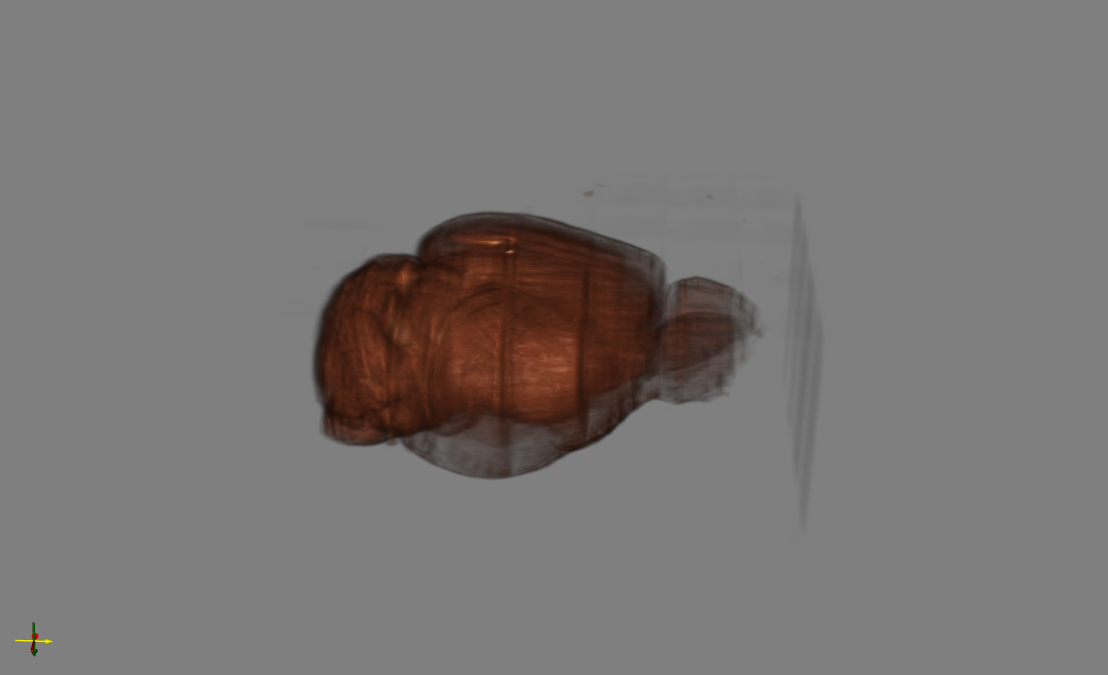
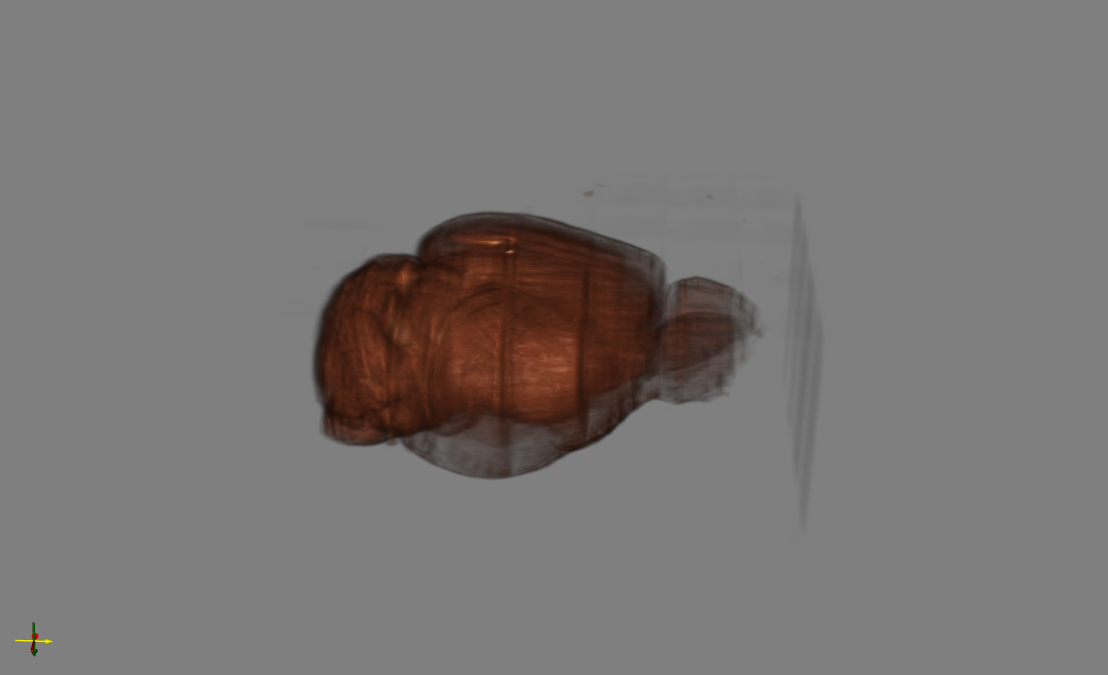

<IPython.core.display.Javascript object>

In [19]:
itkwidgets.compare_images(source_image_init, target_image)

## Register with `itk-elastix`

We use the tools developed in Elastix and made available via the ITKElastix Python module to perform multistage registration.

In [20]:
itk.auto_progress(1)
itk.ElastixRegistrationMethod
itk.auto_progress(0)

Loading ITKVoronoi... Loading ITKVoronoi... Loading ITKQuadEdgeMesh... Loading ITKQuadEdgeMesh... Loading ITKIOMeshBase... Loading ITKIOMeshBYU... Loading ITKIOMeshBYU... Loading ITKIOMeshFreeSurfer... Loading ITKIOMeshFreeSurfer... Loading ITKIOMeshGifti... Loading ITKIOMeshGifti... Loading ITKIOMeshOBJ... Loading ITKIOMeshOBJ... Loading ITKIOMeshOFF... Loading ITKIOMeshOFF... Loading ITKIOMeshVTK... Loading ITKIOMeshVTK... Loading ITKIOMeshBase... Loading Elastix... Loading Elastix... 

In [21]:
parameter_object = itk.ParameterObject.New()
parameter_object.AddParameterMap(
    parameter_object.GetDefaultParameterMap("rigid")
)
parameter_object.AddParameterMap(
    parameter_object.GetDefaultParameterMap("affine")
)

bspline_map = parameter_object.GetDefaultParameterMap("bspline")
bspline_map["FinalGridSpacingInPhysicalUnits"] = ("0.5000",)
parameter_object.AddParameterMap(bspline_map)

print(parameter_object)

ParameterObject (0x55f630f7ce60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 67
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (AutomaticScalesEstimation "true")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (FinalBSplineInterpolationOrder 3)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (ImageSampler "RandomCoordinate")
  (Interpolator "LinearInterpolator")
  (MaximumNumberOfIterations 256)
  (MaximumNumberOfSamplingAttempts 8)
  (Metric "AdvancedMattesMutualInformation")
  (MovingImagePyramid "MovingSmoothingImagePyramid")
  (NewSamplesEveryIteration "true")
  (NumberOfResolutions 4)
  (NumberOfSamplesForExactGradient 4096)
  (NumberOfSpatialSamples 2048)
  (Optimizer "AdaptiveStochasticGradientDescent")
  (Registration "MultiResolutionRegistration")
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

In [22]:
registration_method = itk.ElastixRegistrationMethod[
    type(target_image), type(source_image)
].New(
    fixed_image=target_image,
    moving_image=source_image_init,
    parameter_object=parameter_object,
    log_to_console=False,
)

In [23]:
# Run registration with `itk-elastix`, may take a few minutes
registration_method.Update()

In [24]:
# Verify that the registered source image bounds concide with the target image

print(
    f"Registered source image bounds: {get_bounds(registration_method.GetOutput())[0]},"
    f"{get_bounds(registration_method.GetOutput())[1]}"
)
print(
    f"Target image bounds: {get_bounds(target_image)[0]}, {get_bounds(target_image)[1]}"
)

Registered source image bounds: itkPointD3 ([0, 0, 0]),itkPointD3 ([-11.4, 13.2, -8])
Target image bounds: itkPointD3 ([0, 0, 0]), itkPointD3 ([-11.4, 13.2, -8])


In [25]:
itkwidgets.compare_images(registration_method.GetOutput(), target_image)

<IPython.core.display.Javascript object>

## Save Outputs To Disk

Reproducible results should be saved to the capsule 'data' folder. Registration results from this notebook include:
- The registered, resampled SmartSPIM image. This can be compared with the target CCF average template image or CCF label atlas in a spatial viewer for visual evaluation of registration fitness.
- The sequence of transforms used to map from the source SmartSPIM sample space to target CCF space. We can map corresponding information in SmartSPIM source space such as segmentations or other markups into CCF space by applying this sequence of transformations.
    - The ITK versor transform used to initialize the volumes for registration;
    - The sequence of Elastix transforms generated by registration.



In [25]:
os.makedirs(REGISTERED_IMAGE_OUTPUT_PATH, exist_ok=True)
itk.imwrite(
    registration_method.GetOutput(),
    f"{REGISTERED_IMAGE_OUTPUT_PATH}/{REGISTERED_IMAGE_OUTPUT_FILENAME}",
    compression=True,
)

itk.transformwrite(
    [init_transform], f"{REGISTERED_IMAGE_OUTPUT_PATH}/init-transform.hdf5"
)
for index in range(parameter_object.GetNumberOfParameterMaps()):
    registration_method.GetTransformParameterObject().WriteParameterFile(
        registration_method.GetTransformParameterObject().GetParameterMap(index),
        f"{REGISTERED_IMAGE_OUTPUT_PATH}/elastix-transform{index}.txt",
    )